In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [202]:
df = pd.read_csv("dataset.csv")

df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.sort_values('Date', inplace=True)

scaler = MinMaxScaler()
df['Scaled_Close'] = scaler.fit_transform(df[['Close']])

In [203]:
def create_sequences(data, look_back=30):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

look_back = 30

X, y = create_sequences(df['Scaled_Close'].values, look_back)

X = X.reshape((X.shape[0], X.shape[1], 1))

In [204]:
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout

model = Sequential([
    Input(shape=(look_back, 1)),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

In [210]:
history = model.fit(X, y, epochs=10, batch_size=15, verbose=1, validation_split=0.3)

Epoch 1/10
20/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1156e-04

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1830e-04 - val_loss: 0.0064
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.2667e-04 - val_loss: 0.0054
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6339e-04 - val_loss: 0.0064
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.2279e-04 - val_loss: 0.0063
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.4654e-04 - val_loss: 0.0050
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 6.1936e-04 - val_loss: 0.0044
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5781e-04 - val_loss: 0.0039
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2298e-04 - val_loss: 0.0036
Epoch 9/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5590e-04 - val_loss: 0.0041
Epoch 10/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0086e-04 - val_loss: 0.0034


In [211]:
y_pred_scaled = model.predict(X)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_true = scaler.inverse_transform(y.reshape(-1, 1)).flatten()

24/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [212]:
rmse_score = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print("Root Mean Squared Error (RMSE):", rmse_score)
print("R² Score:", r2)

Root Mean Squared Error (RMSE): 64.75577921853866
R² Score: 0.9679636750986031


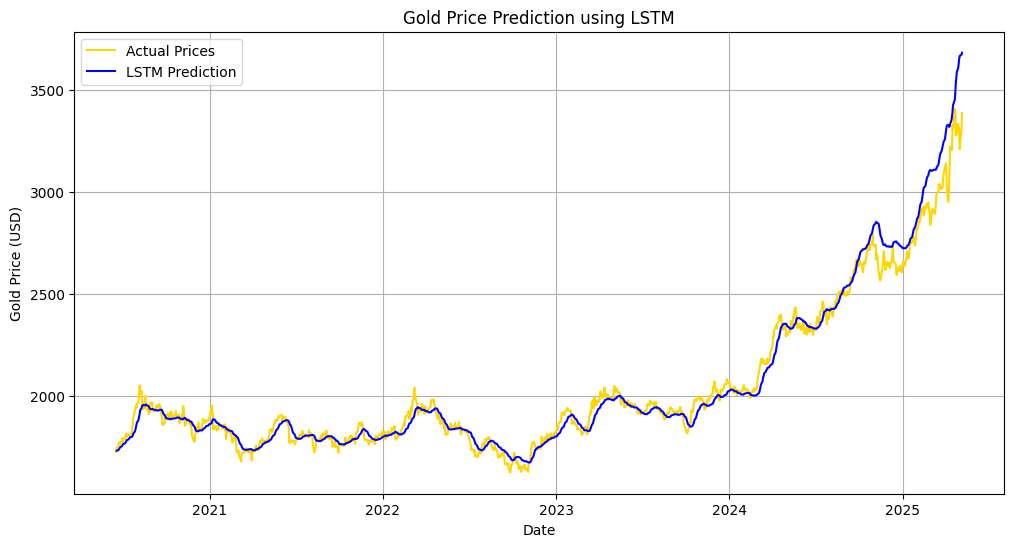

In [213]:
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][look_back:], y_true, label='Actual Prices', color='gold')
plt.plot(df['Date'][look_back:], y_pred, label='LSTM Prediction', color='blue')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.title('Gold Price Prediction using LSTM')
plt.legend()
plt.grid(True)
plt.show()

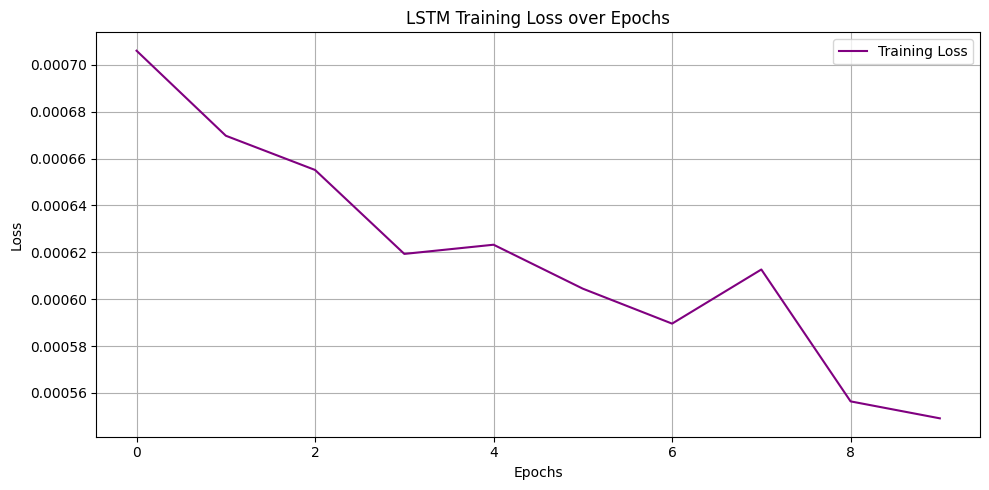

In [214]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='purple')
plt.title("LSTM Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()